# [作業目標]
- 使用 Day 17 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 17 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

# 設定 data_path
dir_data = '../data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 17 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

就年齡離散化後與TARGET的關係來看，似乎年齡越大，還款能力越強

In [5]:
# 根據年齡分成不同組別 (年齡區間 - 還款與否)
age_data = app_train[['TARGET', 'DAYS_BIRTH']] # subset
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365 # day-age to year-age
age_data.head()

,TARGET,DAYS_BIRTH,YEARS_BIRTH
0,1,9461,25.920548
1,0,16765,45.931507
2,0,19046,52.180822
3,0,19005,52.068493
4,0,19932,54.608219


等寬劃分

In [6]:
# 新增欄位 "equal_width_age", 對年齡做等寬劃分
age_data["equal_width_age"] = pd.cut(age_data["YEARS_BIRTH"], 4)

In [7]:
# 觀察等寬劃分下, 每個種組距各出現幾次
# 每個 bin 的值的範圍大小都是一樣的
age_data["equal_width_age"].value_counts()

(32.668, 44.819]    100808
(44.819, 56.97]      84685
(20.469, 32.668]     66536
(56.97, 69.121]      55482
Name: equal_width_age, dtype: int64

In [8]:
# 計算每個年齡區間的 Target、DAYS_BIRTH與 YEARS_BIRTH 的平均值
age_groups  = age_data.groupby('equal_width_age').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
equal_width_age,,,
"(20.469, 32.668]",0.111534,10275.174567,28.151163
"(32.668, 44.819]",0.087067,14164.359981,38.806466
"(44.819, 56.97]",0.068454,18567.511377,50.869894
"(56.97, 69.121]",0.051008,22486.804243,61.607683


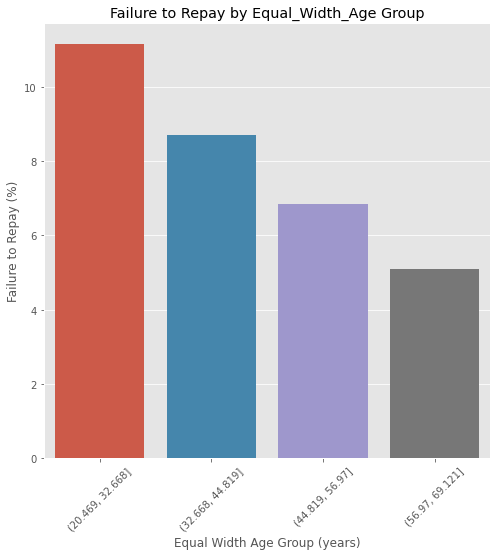

In [9]:
plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot
px = age_groups.index.astype(str)
py = 100 * age_groups['TARGET']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 45); plt.xlabel('Equal Width Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Equal_Width_Age Group');

等頻劃分

In [10]:
# 新增欄位 "equal_freq_age", 對年齡做等頻劃分
age_data["equal_freq_age"] = pd.cut(age_data["YEARS_BIRTH"], 4)

In [11]:
# 觀察等寬劃分下, 每個種組距各出現幾次
# 每個 bin 的值的範圍大小都是一樣的
age_data["equal_freq_age"].value_counts()

(32.668, 44.819]    100808
(44.819, 56.97]      84685
(20.469, 32.668]     66536
(56.97, 69.121]      55482
Name: equal_freq_age, dtype: int64

In [12]:
# 計算每個年齡區間的 Target、DAYS_BIRTH與 YEARS_BIRTH 的平均值
age_groups  = age_data.groupby('equal_freq_age').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
equal_freq_age,,,
"(20.469, 32.668]",0.111534,10275.174567,28.151163
"(32.668, 44.819]",0.087067,14164.359981,38.806466
"(44.819, 56.97]",0.068454,18567.511377,50.869894
"(56.97, 69.121]",0.051008,22486.804243,61.607683


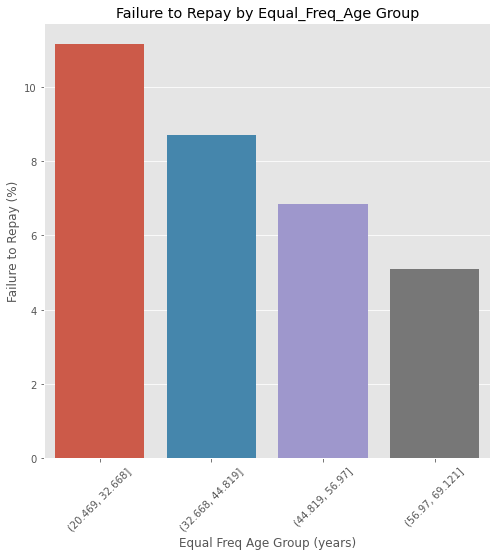

In [13]:
plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot
px = age_groups.index.astype(str)
py = 100 * age_groups['TARGET']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 45); plt.xlabel('Equal Freq Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Equal_Freq_Age Group');

### 目前工作的就職天數離散化後與TARGET的關係來看，似乎就職天數越多，還款能力越強

In [14]:
# DAYS_EMPLOYED 取絕對值 
app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])

等寬劃分

In [15]:
# 根據目前工作的就職天數分成不同組別 (目前工作的就職天數區間 - 還款與否)
EMPLOYED_data = app_train[['TARGET', 'DAYS_EMPLOYED']] # subset

EMPLOYED_data['YEARS_EMPLOYED'] = EMPLOYED_data['DAYS_EMPLOYED'] / 365 # day-age to year-age

In [16]:
# 切6個區間 
EMPLOYED_data['EMPLOYED_WIDTH_YEARS'] = pd.cut(EMPLOYED_data['YEARS_EMPLOYED'], 6)

In [17]:
# 顯示不同組的數量
print(EMPLOYED_data['EMPLOYED_WIDTH_YEARS'].value_counts())
EMPLOYED_data.head()

(-0.0491, 8.179]    182847
(8.179, 16.358]      49515
(16.358, 24.537]     13095
(24.537, 32.716]      4837
(32.716, 40.895]      1663
(40.895, 49.074]       180
Name: EMPLOYED_WIDTH_YEARS, dtype: int64


,TARGET,DAYS_EMPLOYED,YEARS_EMPLOYED,EMPLOYED_WIDTH_YEARS
0,1,637.0,1.745205,"(-0.0491, 8.179]"
1,0,1188.0,3.254795,"(-0.0491, 8.179]"
2,0,225.0,0.616438,"(-0.0491, 8.179]"
3,0,3039.0,8.326027,"(8.179, 16.358]"
4,0,3038.0,8.323288,"(8.179, 16.358]"


In [18]:
EMPLOYED_data.describe()

,TARGET,DAYS_EMPLOYED,YEARS_EMPLOYED
count,307511.000000,252137.000000,252137.000000
mean,0.080729,2384.169325,6.531971
std,0.272419,2338.360162,6.406466
min,0.000000,0.000000,0.000000
25%,0.000000,767.000000,2.101370
50%,0.000000,1648.000000,4.515068
75%,0.000000,3175.000000,8.698630
max,1.000000,17912.000000,49.073973


In [19]:
EMPLOYED_data_groups = EMPLOYED_data.groupby('EMPLOYED_WIDTH_YEARS').mean()
EMPLOYED_data_groups

,TARGET,DAYS_EMPLOYED,YEARS_EMPLOYED
EMPLOYED_WIDTH_YEARS,,,
"(-0.0491, 8.179]",0.098339,1247.270127,3.417178
"(8.179, 16.358]",0.060103,4123.078481,11.296105
"(16.358, 24.537]",0.048186,7248.486140,19.858866
"(24.537, 32.716]",0.042175,10241.028530,28.057612
"(32.716, 40.895]",0.025256,13013.967529,35.654706
"(40.895, 49.074]",0.005556,15702.555556,43.020700


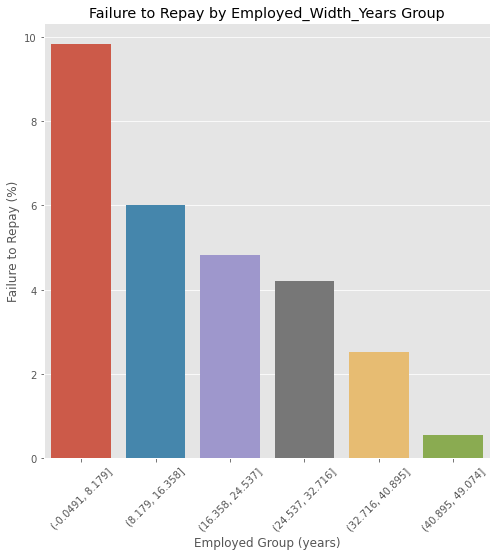

In [20]:
plt.figure(figsize = (8, 8))

# 以目前工作的就職天數區間為 x, target 為 y 繪製 barplot
px = EMPLOYED_data_groups.index.astype(str)
py = 100 * EMPLOYED_data_groups['TARGET']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 45); plt.xlabel('Employed Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Employed_Width_Years Group');

等頻劃分

In [21]:
# 目前工作的就職天數切6個等頻區間 
EMPLOYED_data['EMPLOYED_FREQ_YEARS'] = pd.qcut(EMPLOYED_data['YEARS_EMPLOYED'], 6)

In [22]:
# 顯示不同組的數量
print(EMPLOYED_data['EMPLOYED_FREQ_YEARS'].value_counts())
EMPLOYED_data.head()

(2.808, 4.515]      42076
(-0.001, 1.416]     42044
(7.036, 11.258]     42018
(11.258, 49.074]    42016
(1.416, 2.808]      42004
(4.515, 7.036]      41979
Name: EMPLOYED_FREQ_YEARS, dtype: int64


,TARGET,DAYS_EMPLOYED,YEARS_EMPLOYED,EMPLOYED_WIDTH_YEARS,EMPLOYED_FREQ_YEARS
0,1,637.0,1.745205,"(-0.0491, 8.179]","(1.416, 2.808]"
1,0,1188.0,3.254795,"(-0.0491, 8.179]","(2.808, 4.515]"
2,0,225.0,0.616438,"(-0.0491, 8.179]","(-0.001, 1.416]"
3,0,3039.0,8.326027,"(8.179, 16.358]","(7.036, 11.258]"
4,0,3038.0,8.323288,"(8.179, 16.358]","(7.036, 11.258]"


In [23]:
EMPLOYED_data.describe()

,TARGET,DAYS_EMPLOYED,YEARS_EMPLOYED
count,307511.000000,252137.000000,252137.000000
mean,0.080729,2384.169325,6.531971
std,0.272419,2338.360162,6.406466
min,0.000000,0.000000,0.000000
25%,0.000000,767.000000,2.101370
50%,0.000000,1648.000000,4.515068
75%,0.000000,3175.000000,8.698630
max,1.000000,17912.000000,49.073973


In [24]:
EMPLOYED_data_groups = EMPLOYED_data.groupby('EMPLOYED_FREQ_YEARS').mean()
EMPLOYED_data_groups

,TARGET,DAYS_EMPLOYED,YEARS_EMPLOYED
EMPLOYED_FREQ_YEARS,,,
"(-0.001, 1.416]",0.112501,292.348278,0.800954
"(1.416, 2.808]",0.110204,768.379964,2.105151
"(2.808, 4.515]",0.098132,1321.201683,3.619731
"(4.515, 7.036]",0.081708,2073.889326,5.681889
"(7.036, 11.258]",0.067257,3232.059594,8.854958
"(11.258, 49.074]",0.049767,6619.273991,18.134997


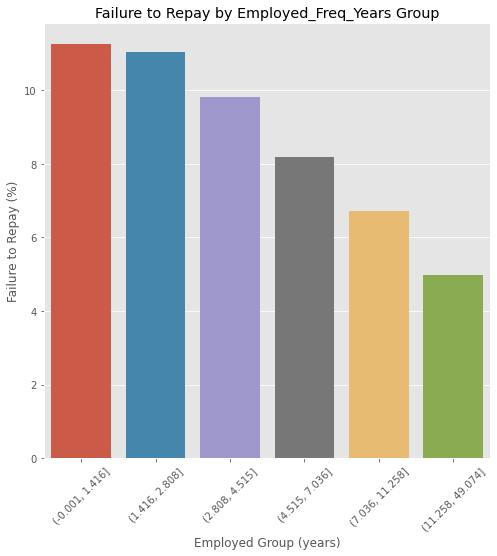

In [25]:
plt.figure(figsize = (8, 8))

# 以目前工作的就職天數區間為 x, target 為 y 繪製 barplot
px = EMPLOYED_data_groups.index.astype(str)
py = 100 * EMPLOYED_data_groups['TARGET']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 45); plt.xlabel('Employed Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Employed_Freq_Years Group');